In [86]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 협업 필터링 구현에 필요한 패키지
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

In [87]:
rating_data = pd.read_csv("data/241220/ratings_small.csv")
movie_data = pd.read_csv("data/241220/movies_metadata.csv")

C:\Users\YoungJin\AppData\Local\Temp\ipykernel_7292\2967785821.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_data = pd.read_csv("data/241220/movies_metadata.csv")


In [88]:
rating_data

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [104]:
movie_data

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [105]:
# for _, row in movie_data[['id', 'title']].iterrows():
#     print(type(row))
#     print(row)
#     print(row.get('id'), row.get('title'))
#     print(list(row))
#     break

id_to_title = {row['id']: row['title'] for _, row in movie_data[['id', 'title']].iterrows()}
print(id_to_title['862'])

Toy Story


In [91]:
title_to_id = {v: k for k, v in id_to_title.items()}
print(title_to_id['Iron Man'])

194310


- 영화별 평점 수 확인
- 히스토그램 형태로 시각화

movieId
1    247
2    107
3     59
4     13
5     56
Name: rating, dtype: int64


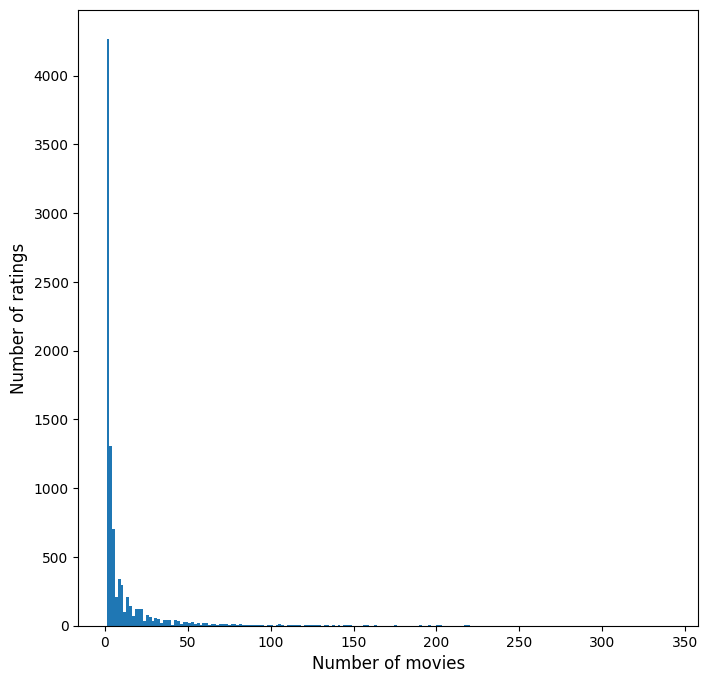

In [92]:
# 유저 평점 데이터들 중 동일한 movieId를 가진 샘플들을 묶어(groupby) 각 영화에 대한 평점이 몇개인지 확인
movie_rating_count = rating_data.groupby('movieId')['rating'].count()
print(movie_rating_count.head())

# 히스토그램 시각화
plt.figure(figsize=(8, 8))
fig = plt.hist(movie_rating_count, bins=200)
plt.xlabel('Number of movies', fontsize=12)
plt.ylabel('Number of ratings', fontsize=12)
plt.show()

In [93]:
print('평점 데이터 내에 있는 총 영화 수: ', len(rating_data['movieId'].unique()))
print('10개 이상의 평점을 받은 영화 수', len(movie_rating_count[movie_rating_count >= 10]))
print('100개 이상의 평점을 받은 영화 수', len(movie_rating_count[movie_rating_count >= 100]))

평점 데이터 내에 있는 총 영화 수:  9066
10개 이상의 평점을 받은 영화 수 2245
100개 이상의 평점을 받은 영화 수 151


In [94]:
movie_rating_info = rating_data.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_rating_info.columns = ['rated_count', 'rating_mean']
movie_rating_info

,rated_count,rating_mean
movieId,,
1,247,3.872470
2,107,3.401869
3,59,3.161017
4,13,2.384615
5,56,3.267857
...,...,...
161944,1,5.000000
162376,1,4.500000
162542,1,5.000000


<Axes: >

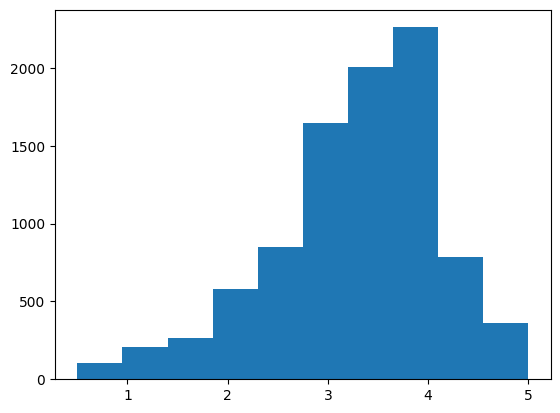

In [95]:
movie_rating_info['rating_mean'].hist(grid=False)

In [96]:
# 100번 이상의 평가를 받은 영화 중, 평점이 높은 10개의 영화를 출력
# top_rated_movies = movie_rating_info[movie_rating_info['rated_count'] >= 100].sort_values(by='rating_mean', ascending=False).head(10)
# print(top_rated_movies)
indices_enough_eval = movie_rating_info['rated_count'] > 100
indices_enough_eval

movieId
1          True
2          True
3         False
4         False
5         False
          ...  
161944    False
162376    False
162542    False
162672    False
163949    False
Name: rated_count, Length: 9066, dtype: bool

In [97]:
# 평가 수가 100개 이상인 영화들만 선택 후 최고 평점인 10개 영화의 id 확인
top_10_movies = movie_rating_info[indices_enough_eval].nlargest(10, 'rating_mean')
top_10_movies

,rated_count,rating_mean
movieId,,
858,200,4.487500
318,311,4.487138
1221,135,4.385185
50,201,4.370647
527,244,4.303279
1193,144,4.256944
608,224,4.256696
296,324,4.256173
2858,220,4.236364


In [106]:
# 영화 정보 확인
for movie_id, (count, score) in top_10_movies.iterrows():
    try:
        title = id_to_title[str(movie_id)]
    except KeyError:
        title = f'unkown movie id: {movie_id}'

    print(f'{title}, score: {score:.03}, count: {int(count)}')

Sleepless in Seattle, score: 4.49, count: 200
The Million Dollar Hotel, score: 4.49, count: 311
unkown movie id: 1221, score: 4.39, count: 135
unkown movie id: 50, score: 4.37, count: 201
Once Were Warriors, score: 4.3, count: 244
unkown movie id: 1193, score: 4.26, count: 144
Men in Black II, score: 4.26, count: 224
Terminator 3: Rise of the Machines, score: 4.26, count: 324
unkown movie id: 2858, score: 4.24, count: 220
Confession of a Child of the Century, score: 4.24, count: 121
